In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import KMeans
from tqdm import tqdm

In [2]:
import numpy as np
import scipy.sparse as sp


In [3]:
def calc_ei(pxy):
    # normalizing p(x, y)
    p = pxy / pxy.sum()
    
    # dimension of x and y
    m, n = p.shape
    
    # marginal distributions
    px = p.sum(axis=1)
    py = p.sum(axis=0)
    
    # do(x) to uniform distribution, tpm = p(y|x)
    tpm = (p.T / px).T
    pu = tpm / tpm.sum()
    
    # marginal distribution of y given x ~ Unifrom Dist
    puy = pu.sum(axis=0)
    
    # replace 0 to a small positive number to avoid log error
    eps = 1E-10
    tpm_e = np.where(tpm==0, eps, tpm)
    puy_e = np.where(tpm==0, eps, puy)
    
    # calculate EI of specific x
    ei_x = (np.log2(tpm_e / puy_e) * tpm).sum(axis=1)
    
    # calculate determinism and degeneracy coefficients of specific x
    det_x = (np.log2(tpm_e * m) * tpm).sum(axis=1) / np.log2(m)
    deg_x = (np.log2(puy_e * m) * tpm).sum(axis=1) / np.log2(m)
    
    # calculate total EI
    ei_all = ei_x.mean()
    
    # calculate determinism and degeneracy coefficients, and efficiency
    det = det_x.mean()
    deg = deg_x.mean()
    eff = det - deg
    
    return tpm, eff, det, deg, ei_all, ei_x, det_x, deg_x

def set_plot_info(xlabel,ylabel,fontsize=14):
    plt.xlabel(xlabel,fontsize=fontsize)
    plt.ylabel(ylabel,fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

In [4]:
def generate_sbm(n, p, q, k):
    """
    Generate an adjacency matrix for a Stochastic Block Model.
    
    Parameters:
    n (int): Total number of nodes.
    p (float): Intra-block connection probability.
    q (float): Inter-block connection probability.
    sizes (list of int): Sizes of each block.
    
    Returns:
    scipy.sparse.csr_matrix: Adjacency matrix of the SBM.
    """
    # Number of blocks
    k = len(sizes)
    
    # Check if sizes sum to n
    assert sum(sizes) == n, "Sizes must sum to n"
    
    # Create block indices
    block_indices = np.repeat(np.arange(k), sizes)
    
    # Initialize an empty adjacency matrix
    adj_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1, n):
            if block_indices[i] == block_indices[j]:
                # Intra-block connection
                if np.random.rand() < p:
                    adj_matrix[i, j] = adj_matrix[j, i] = 1
            else:
                # Inter-block connection
                if np.random.rand() < q:
                    adj_matrix[i, j] = adj_matrix[j, i] = 1
    
    # return sp.csr_matrix(adj_matrix)
    return block_indices,adj_matrix


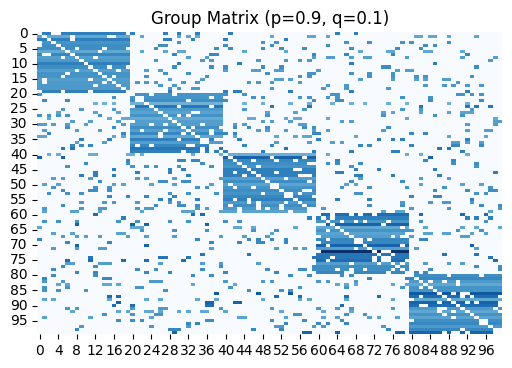

Gamma=13.30,gamma=0.13
(5, 5)


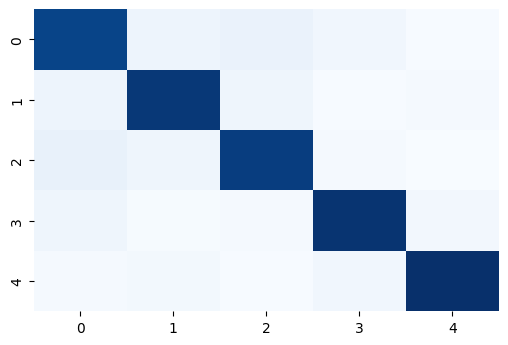

Gamma=3.33,gamma=0.67
Delta gamma = 0.53


In [7]:
# Example usage
n = 100  # Total number of nodes
p = 0.9  # Intra-block connection probability
q = 0.1  # Inter-block connection probability
sizes = [20, 20, 20, 20, 20]  # Sizes of each block
np.random.seed(2050)
block_indices, pxy = generate_sbm(n, p, q, sizes)

# Normalize 'flow' to create 'markov'
markov = np.zeros_like(pxy)
for i in range(len(markov)):
    normalize = np.sum(pxy[i, :])
    if normalize > 0:
        markov[i, :] = pxy[i, :] / normalize

# Perform SVD
U, original_S, V = np.linalg.svd(markov, full_matrices=False)
original_S_09_01 = original_S

import seaborn as sns
plt.figure(dpi=100)
sns.heatmap(markov, cmap='Blues', cbar=False)
plt.title('Group Matrix (p='+str(p)+', q='+str(q)+')')#,fontsize=30)
plt.show()
print(f'Gamma={original_S.sum():.2f},gamma={original_S.sum()/100:.2f}')


'coarse-graining'
r=5
kmeans = KMeans(n_clusters=r,random_state=1)
kmeans.fit(markov)
labels = [(i,kmeans.labels_[i]) for i in range(len(kmeans.labels_))]
cluster_centers = kmeans.cluster_centers_
r=5
phi = np.zeros([n,r])
for i in range(len(labels)):
    phi[labels[i][0],labels[i][1]] = 1

reduced_flow = phi.T @ pxy @ phi

# Normalize the reduced flow matrix to create a reduced Markov matrix
reduced_markov = reduced_flow.copy()
for i in range(reduced_flow.shape[0]):
    normalize = np.sum(reduced_flow[i, :])
    if normalize > 0:
        reduced_markov[i, :] = reduced_flow[i, :] / normalize
    else:
        reduced_markov[i, :] = np.zeros(reduced_markov.shape[1])
        
print(reduced_markov.shape)
U, reduced_S, V = np.linalg.svd(reduced_markov, full_matrices=False)
plt.figure(dpi=100)
sns.heatmap(reduced_markov, cmap='Blues', cbar=False)
plt.show()
print(f'Gamma={reduced_S.sum():.2f},gamma={reduced_S.sum()/5:.2f}')
print(f'Delta gamma = {reduced_S.sum()/5-original_S.sum()/100:.2f}')

In [8]:
print(f'$\Gamma=$',original_S_09_01.sum())
print(f'$\gamma=$',original_S_09_01.sum()/n)

$\Gamma=$ 13.296450157180049
$\gamma=$ 0.13296450157180048


In [9]:
block_indices,pxy.shape

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]),
 (100, 100))

(100,) {0, 1, 2, 3, 4}


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


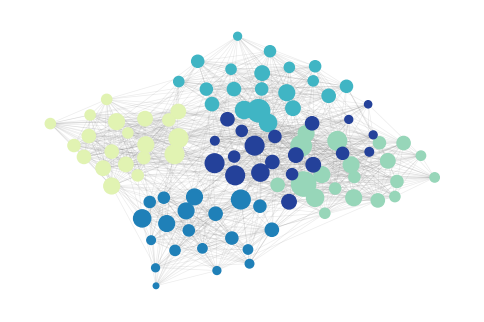

In [100]:

G = nx.Graph()
n = pxy.shape[0]

for i in range(n):
    G.add_node(i)


for i in range(n):
    for j in range(i+1, n):
        if pxy[i, j] != 0:
            G.add_edge(i, j)
                
#degrees list, setting as node size
degrees = np.array([G.degree(n) for n in G.nodes()])
node_sizes = np.power(2,degrees/4)

plt.figure(dpi=100)
n = len(pxy)

group_matrix = np.zeros((n, 5))
for i in range(5):
    group_matrix[20*i:20*(i+1), i] = 1

group_list = np.repeat(np.arange(5), sizes)
print(group_list.shape,set(group_list))

colors = []
labels = {}
for i in range(n):
    colors.append(plt.cm.YlGnBu((group_list[i]+1)/(len(set(group_list))+1)) )

pos = nx.spring_layout(G,weight='weight',seed=1)
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=colors)

weights = np.array([G[u][v].get('weight', 1) for u, v in G.edges()])
weights_normalized = (weights - weights.min()) / (weights.max() - weights.min())
cmap = plt.cm.Blues 

edges = nx.draw_networkx_edges(G, pos, alpha=0.15, edge_color='grey', width=0.5)
plt.axis("off")

plt.show()

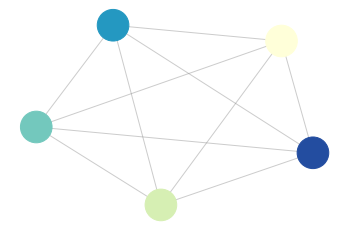

In [10]:

G = nx.Graph()
n = reduced_flow.shape[0]

for i in range(n):
    G.add_node(i)


for i in range(n):
    for j in range(i+1, n):  
        if reduced_flow[i, j] != 0: 
            G.add_edge(i, j)
counts = 5
colors = [plt.cm.YlGnBu(i / counts) for i in range(counts)]
pos = nx.spring_layout(G,weight='weight',seed=0)  
nx.draw_networkx_nodes(G, pos, node_color=colors,node_size=1000)

edges = nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color='grey', width=1)
plt.axis("off")

plt.show()

In [11]:
# Example usage
n = 100  # Total number of nodes
p = 0.85  # Intra-block connection probability
q = 0.15  # Inter-block connection probability
sizes = [20, 20, 20, 20, 20]  # Sizes of each block

block_indices,pxy = generate_sbm(n, p, q, sizes)

# Normalize 'flow' to create 'markov'
markov = np.zeros_like(pxy)
for i in range(len(markov)):
    normalize = np.sum(pxy[i, :])
    if normalize > 0:
        markov[i, :] = pxy[i, :] / normalize

# Perform SVD
U, original_S, V = np.linalg.svd(markov, full_matrices=False)
original_S_085_015 = original_S


In [12]:
# Example usage
n = 100  # Total number of nodes
p = 0.8  # Intra-block connection probability
q = 0.2  # Inter-block connection probability
sizes = [20, 20, 20, 20, 20]  # Sizes of each block

block_indices,pxy = generate_sbm(n, p, q, sizes)

# Normalize 'flow' to create 'markov'
markov = np.zeros_like(pxy)
for i in range(len(markov)):
    normalize = np.sum(pxy[i, :])
    if normalize > 0:
        markov[i, :] = pxy[i, :] / normalize

# Perform SVD
U, original_S, V = np.linalg.svd(markov, full_matrices=False)
original_S_08_02 = original_S


In [15]:
counts = 5
colors = [plt.cm.YlGnBu(i / counts) for i in range(counts)]

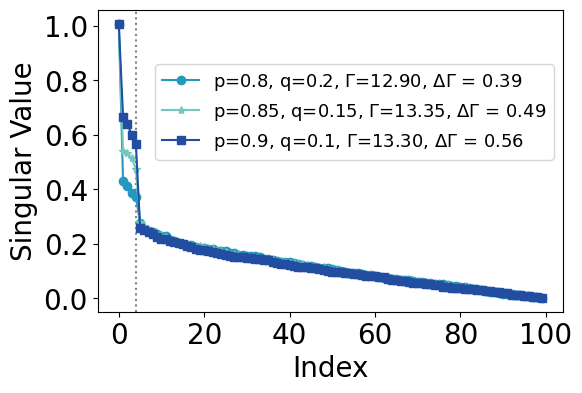

In [16]:

plt.figure(dpi=100)
plt.axvline(4, c='grey', linestyle=':')
delta_Gamma = original_S_08_02[:5].sum()/5 - original_S_08_02.sum()/100
plt.plot(original_S_08_02, color=colors[3],marker='o',
         label=f'p=0.8, q=0.2, $\Gamma$={np.sum(original_S_08_02):.2f},'+f' $\Delta \Gamma$ = {delta_Gamma:.2f}')

delta_Gamma = original_S_085_015[:5].sum()/5 - original_S_08_02.sum()/100
plt.plot(original_S_085_015, color=colors[2],marker='*',
         label=f'p=0.85, q=0.15, $\Gamma$={np.sum(original_S_085_015):.2f},'+f' $\Delta \Gamma$ = {delta_Gamma:.2f}')

delta_Gamma = original_S_09_01[:5].sum()/5 - original_S_09_01.sum()/100
plt.plot(original_S_09_01, color=colors[-1],marker='s',
         label=f'p=0.9, q=0.1, $\Gamma$={np.sum(original_S_09_01):.2f},'+f' $\Delta \Gamma$ = {delta_Gamma:.2f}')
set_plot_info('Index','Singular Value',fontsize=20)

plt.legend(fontsize=13,bbox_to_anchor=(1, -0.15, 0, 1))
